# Notebook for Cleaning Pro Football Reference Fantasy Passing Tables

In [533]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get current directory
import os

# Set working directory
os.chdir('C:\\Users\\Jack\\Documents\\GitHub\\FFInsights\\data')

In [534]:
# Load passing data
for year in range(2013, 2024):
    file_name = f'{year}_nfl_passing_profootballreference.csv'
    globals()[f'pass_{year}'] = pd.read_csv(file_name)

# Load in rushing data
for year in range(2013, 2024):
    file_name = f'{year}_pfr_rushing.csv'
    globals()[f'rush_{year}'] = pd.read_csv(file_name)

In [535]:
# print columns that are unique between all rush_years
cols = []
for year in range(2013, 2024):
    cols.append(globals()[f'rush_{year}'].columns)
cols = [list(x) for x in set(tuple(x) for x in cols)]
unique_cols = list(set(cols[0]).intersection(*cols))
print(unique_cols)


['1D', 'Lng', 'Pos', 'Rk', 'TD', 'Att', '-9999', 'GS', 'Succ%', 'Y/A', 'Y/G', 'G', 'Age', 'Fmb', 'Tm', 'Yds', 'Player']


# Preprocessing

In [536]:
# Transform rush data
for year in range(2013, 2024):
    # Rename 'Att' tp 'Rush_Att'
    globals()[f'rush_{year}'].rename(columns={'Att': 'Rush_Att'}, inplace=True)
    globals()[f'rush_{year}'].rename(columns={'Yds': 'Rush_Yds'}, inplace=True)
    globals()[f'rush_{year}'].rename(columns={'TD': 'Rush_TD'}, inplace=True)
    globals()[f'rush_{year}'].rename(columns={'1D': 'Rush_1D'}, inplace=True)
    globals()[f'rush_{year}'].rename(columns={'Succ%': 'Rush_Succ%'}, inplace=True)
    globals()[f'rush_{year}'].rename(columns={'Lng': 'Rush_Lng'}, inplace=True)
    globals()[f'rush_{year}'].rename(columns={'Y/A': 'Rush_YperA'}, inplace=True)
    globals()[f'rush_{year}'].rename(columns={'Y/G': 'Rush_YperG'}, inplace=True)
    # Remove '-9999' column
    globals()[f'rush_{year}'] = globals()[f'rush_{year}'].drop(columns=['-9999'])
    # Remove 'Rk' column
    globals()[f'rush_{year}'] = globals()[f'rush_{year}'].drop(columns=['Rk'])
    # Filter 'Pos' to only have 'QB'
    globals()[f'rush_{year}'] = globals()[f'rush_{year}'][globals()[f'rush_{year}']['Pos'] == 'QB']


In [537]:
# Merge passing and rushing data
for year in range(2013, 2024):
    globals()[f'pass_{year}'] = pd.merge(globals()[f'pass_{year}'], globals()[f'rush_{year}'], 
                                         on=['Player', 'Tm', 'Age', 'Pos', 'G', 'GS'], 
                                         how='left')

# Transform data
for year in range(2013, 2024):
    # Rename 'Yds.1' to 'Sack_Yds'
    globals()[f'pass_{year}'].rename(columns={'Yds.1': 'Sack_Yds'}, inplace=True)
    # Make new column 'ProBowl' if * is in 'Player'
    globals()[f'pass_{year}']['ProBowl'] = np.where(globals()[f'pass_{year}']['Player'].str.contains('\*'), 1, 0)
    # Make new column 'Allpro' if + is in 'Player'
    globals()[f'pass_{year}']['AllPro'] = np.where(globals()[f'pass_{year}']['Player'].str.contains('\+'), 1, 0)
    # Replace Nan values in 'QBR' with 0
    globals()[f'pass_{year}']['QBR'].fillna(0, inplace=True)
    # Replace Nan values in 'QBrec' with 0
    globals()[f'pass_{year}']['QBrec'].fillna('0-0', inplace=True)
    # Replace Nan values in 'GWD' with 0
    globals()[f'pass_{year}']['GWD'].fillna(0, inplace=True)
    # Make new column 'Wins' from first number in 'QBrec'
    globals()[f'pass_{year}']['Wins'] = globals()[f'pass_{year}']['QBrec'].str.extract(r'(\d+)-').astype(int)
    # Make new column 'Losses' from second number in 'QBrec'
    globals()[f'pass_{year}']['Losses'] = globals()[f'pass_{year}']['QBrec'].str.extract(r'-(\d+)').astype(int)
    # Make new column 'WinPct' from 'Wins' and 'Losses'
    globals()[f'pass_{year}']['WinPct'] = globals()[f'pass_{year}']['Wins'] / (globals()[f'pass_{year}']['Wins'] + globals()[f'pass_{year}']['Losses'])
    # Replace Nan values in 'WinPct' with 0
    globals()[f'pass_{year}']['WinPct'].fillna(0, inplace=True)
    # Replace Nan values in 'Rush_YperA', 'Rush_Att', 'Rush_Yds', 'Rush_TD', 'Rush_1D', 'Rush_Succ%', 'Rush_Lng', 'Fmb' with 0
    globals()[f'pass_{year}']['Rush_Att'].fillna(0, inplace=True)
    globals()[f'pass_{year}']['Rush_Yds'].fillna(0, inplace=True)
    globals()[f'pass_{year}']['Rush_TD'].fillna(0, inplace=True)
    globals()[f'pass_{year}']['Rush_1D'].fillna(0, inplace=True)
    globals()[f'pass_{year}']['Rush_Succ%'].fillna(0, inplace=True)
    globals()[f'pass_{year}']['Rush_Lng'].fillna(0, inplace=True)
    globals()[f'pass_{year}']['Rush_YperA'].fillna(0, inplace=True)
    globals()[f'pass_{year}']['Rush_YperG'].fillna(0, inplace=True)
    globals()[f'pass_{year}']['Fmb'].fillna(0, inplace=True)
    globals()[f'pass_{year}']['4QC'].fillna(0, inplace=True)
    # Make new column 'FntsyPnts' from 'Yds' and 'TD' and 'Int' and 'Rush_Yds' and 'Rush_TD' and 'Fmb'
    globals()[f'pass_{year}']['FntsyPnts'] = globals()[f'pass_{year}']['Yds']*0.04 + globals()[f'pass_{year}']['TD']*4 - globals()[f'pass_{year}']['Int']*2 + globals()[f'pass_{year}']['Rush_Yds']*0.1 + globals()[f'pass_{year}']['Rush_TD']*6 - globals()[f'pass_{year}']['Fmb']*2

In [538]:
# Remove * and + from 'Player'
for year in range(2013, 2024):
    globals()[f'pass_{year}']['Player'] = globals()[f'pass_{year}']['Player'].str.replace('*', '')
    globals()[f'pass_{year}']['Player'] = globals()[f'pass_{year}']['Player'].str.replace('+', '')

# Remove columns
for year in range(2013, 2024):
    globals()[f'pass_{year}'].drop(columns='QBrec', inplace=True)
    globals()[f'pass_{year}'].drop(columns='Player-additional', inplace=True)
    globals()[f'pass_{year}'].drop(columns='Rk', inplace=True)
    globals()[f'pass_{year}'].drop(columns='Tm', inplace=True)
    globals()[f'pass_{year}'].drop(columns='Pos', inplace=True)
    globals()[f'pass_{year}'].drop(columns='Wins', inplace=True)
    globals()[f'pass_{year}'].drop(columns='Losses', inplace=True)

# Replace '/' in column names with 'per'
for year in range(2013, 2024):
    globals()[f'pass_{year}'].columns = globals()[f'pass_{year}'].columns.str.replace('/', 'per')
    # Replace '%' in column names with 'Pct'
    globals()[f'pass_{year}'].columns = globals()[f'pass_{year}'].columns.str.replace('%', 'Pct')
    # Rename '1D' to 'Pass_1D'
    globals()[f'pass_{year}'].rename(columns={'1D': 'Pass_1D'}, inplace=True)
    # Rename '4QC' to 'FourthQC'
    globals()[f'pass_{year}'].rename(columns={'4QC': 'FourthQC'}, inplace=True)

C:\Users\Jack\AppData\Local\Temp\ipykernel_9948\2594483169.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  globals()[f'pass_{year}']['Player'] = globals()[f'pass_{year}']['Player'].str.replace('*', '')
C:\Users\Jack\AppData\Local\Temp\ipykernel_9948\2594483169.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  globals()[f'pass_{year}']['Player'] = globals()[f'pass_{year}']['Player'].str.replace('+', '')


In [539]:
# Preview feature names and data types
pass_2013.columns

Index(['Player', 'Age', 'G', 'GS', 'Cmp', 'Att', 'CmpPct', 'Yds', 'TD',
       'TDPct', 'Int', 'IntPct', 'Pass_1D', 'SuccPct', 'Lng', 'YperA',
       'AYperA', 'YperC', 'YperG', 'Rate', 'QBR', 'Sk', 'Sack_Yds', 'SkPct',
       'NYperA', 'ANYperA', 'FourthQC', 'GWD', 'Rush_Att', 'Rush_Yds',
       'Rush_TD', 'Rush_1D', 'Rush_SuccPct', 'Rush_Lng', 'Rush_YperA',
       'Rush_YperG', 'Fmb', 'ProBowl', 'AllPro', 'WinPct', 'FntsyPnts'],
      dtype='object')

In [540]:
# Make new dfs for each year with only 'FntsyPnts' and 'Player'
for year in range(2013, 2024):
    globals()[f'fntsy_{year}'] = globals()[f'pass_{year}'][['Player', 'FntsyPnts']]
    # Rename 'FntsyPnts' to 'FntsyPnts_y'
    globals()[f'fntsy_{year}'].rename(columns={'FntsyPnts': 'FntsyPnts_y'}, inplace=True)

# New Tables

In [541]:
# Define a function that can summarise sets of years
def process_dataframes(dfs, min_appearances):
    # Combine dataframes vertically
    combined = pd.concat(dfs, axis=0)

    # Remove players that appear less than min_appearances times
    player_counts = combined['Player'].value_counts()
    valid_players = player_counts[player_counts >= min_appearances].index
    combined = combined[combined['Player'].isin(valid_players)]

    # Group by 'Player' and average all other columns
    combined = combined.groupby('Player').mean().round(2)

    return combined

In [542]:
# Create triplets of all years
n = 3
pass_2013_2014_2015 = process_dataframes([pass_2013, pass_2014, pass_2015], n)
pass_2014_2015_2016 = process_dataframes([pass_2014, pass_2015, pass_2016], n)
pass_2015_2016_2017 = process_dataframes([pass_2015, pass_2016, pass_2017], n)
pass_2016_2017_2018 = process_dataframes([pass_2016, pass_2017, pass_2018], n)
pass_2017_2018_2019 = process_dataframes([pass_2017, pass_2018, pass_2019], n)
pass_2018_2019_2020 = process_dataframes([pass_2018, pass_2019, pass_2020], n)
pass_2019_2020_2021 = process_dataframes([pass_2019, pass_2020, pass_2021], n)
pass_2020_2021_2022 = process_dataframes([pass_2020, pass_2021, pass_2022], n)
pass_2021_2022_2023 = process_dataframes([pass_2021, pass_2022, pass_2023], n)

# Merge 'fntsy_year' to each triplet
pass_2013_2014_2015 = pd.merge(pass_2013_2014_2015, fntsy_2016, on='Player', how='left')
pass_2014_2015_2016 = pd.merge(pass_2014_2015_2016, fntsy_2017, on='Player', how='left')
pass_2015_2016_2017 = pd.merge(pass_2015_2016_2017, fntsy_2018, on='Player', how='left')
pass_2016_2017_2018 = pd.merge(pass_2016_2017_2018, fntsy_2019, on='Player', how='left')
pass_2017_2018_2019 = pd.merge(pass_2017_2018_2019, fntsy_2020, on='Player', how='left')
pass_2018_2019_2020 = pd.merge(pass_2018_2019_2020, fntsy_2021, on='Player', how='left')
pass_2019_2020_2021 = pd.merge(pass_2019_2020_2021, fntsy_2022, on='Player', how='left')
pass_2020_2021_2022 = pd.merge(pass_2020_2021_2022, fntsy_2023, on='Player', how='left')

# Concatenate all triplets
triplets = pd.concat([pass_2013_2014_2015, pass_2014_2015_2016, pass_2015_2016_2017, 
                      pass_2016_2017_2018, pass_2017_2018_2019, pass_2018_2019_2020, 
                      pass_2019_2020_2021, pass_2020_2021_2022], axis=0)

triplets = triplets.reset_index()

# Save df to csv
triplets.to_csv('pass_triplets.csv', index=False)


In [543]:
# Create twins of all years
n = 2
pass_2013_2014 = process_dataframes([pass_2013, pass_2014], n)
pass_2014_2015 = process_dataframes([pass_2014, pass_2015], n)
pass_2015_2016 = process_dataframes([pass_2015, pass_2016], n)
pass_2016_2017 = process_dataframes([pass_2016, pass_2017], n)
pass_2017_2018 = process_dataframes([pass_2017, pass_2018], n)
pass_2018_2019 = process_dataframes([pass_2018, pass_2019], n)
pass_2019_2020 = process_dataframes([pass_2019, pass_2020], n)
pass_2020_2021 = process_dataframes([pass_2020, pass_2021], n)
pass_2021_2022 = process_dataframes([pass_2021, pass_2022], n)
pass_2022_2023 = process_dataframes([pass_2022, pass_2023], n)

# Merge 'fntsy_year' to each twin
pass_2013_2014 = pd.merge(pass_2013_2014, fntsy_2015, on='Player', how='left')
pass_2014_2015 = pd.merge(pass_2014_2015, fntsy_2016, on='Player', how='left')
pass_2015_2016 = pd.merge(pass_2015_2016, fntsy_2017, on='Player', how='left')
pass_2016_2017 = pd.merge(pass_2016_2017, fntsy_2018, on='Player', how='left')
pass_2017_2018 = pd.merge(pass_2017_2018, fntsy_2019, on='Player', how='left')
pass_2018_2019 = pd.merge(pass_2018_2019, fntsy_2020, on='Player', how='left')
pass_2019_2020 = pd.merge(pass_2019_2020, fntsy_2021, on='Player', how='left')
pass_2020_2021 = pd.merge(pass_2020_2021, fntsy_2022, on='Player', how='left')
pass_2021_2022 = pd.merge(pass_2021_2022, fntsy_2023, on='Player', how='left')

# Concatenate all twins
twins = pd.concat([pass_2013_2014, pass_2014_2015, pass_2015_2016, pass_2016_2017,
                   pass_2017_2018, pass_2018_2019, pass_2019_2020,
                   pass_2020_2021, pass_2021_2022], axis=0)

twins = twins.reset_index()

# Save df to csv
twins.to_csv('pass_twins.csv', index=False)

In [544]:
# Merge 'fntsy_year' to each single
pass_2013 = pd.merge(pass_2013, fntsy_2014, on='Player', how='left')
pass_2014 = pd.merge(pass_2014, fntsy_2015, on='Player', how='left')
pass_2015 = pd.merge(pass_2015, fntsy_2016, on='Player', how='left')
pass_2016 = pd.merge(pass_2016, fntsy_2017, on='Player', how='left')
pass_2017 = pd.merge(pass_2017, fntsy_2018, on='Player', how='left')
pass_2018 = pd.merge(pass_2018, fntsy_2019, on='Player', how='left')
pass_2019 = pd.merge(pass_2019, fntsy_2020, on='Player', how='left')
pass_2020 = pd.merge(pass_2020, fntsy_2021, on='Player', how='left')
pass_2021 = pd.merge(pass_2021, fntsy_2022, on='Player', how='left')
pass_2022 = pd.merge(pass_2022, fntsy_2023, on='Player', how='left')

# Concatenate all singles
singles = pd.concat([pass_2013, pass_2014, pass_2015, pass_2016, 
                     pass_2017, pass_2018, pass_2019, pass_2020, 
                     pass_2021, pass_2022], axis=0)

singles = singles.reset_index()

# Save df to csv
singles.to_csv('pass_singles.csv', index=False)

In [545]:
# Save pass_2023 to csv 
pass_2023.to_csv('2023_nfl_passing_profootballreference_pred.csv', index=False)

# Save pass_2022_2023 to csv
pass_2022_2023 = pass_2022_2023.reset_index()
pass_2022_2023.to_csv('2022_2023_nfl_passing_profootballreference_pred.csv', index=False)

# Save pass_2021_2022_2023 to csv
pass_2021_2022_2023 = pass_2021_2022_2023.reset_index()
pass_2021_2022_2023.to_csv('2021_2022_2023_nfl_passing_profootballreference_pred.csv', index=False)

In [434]:
# Print Lengths of DataFrames
print('Singles:', len(singles))
print('Twins:', len(twins))
print('Triplets:', len(triplets))

Singles: 600
Twins: 414
Triplets: 287


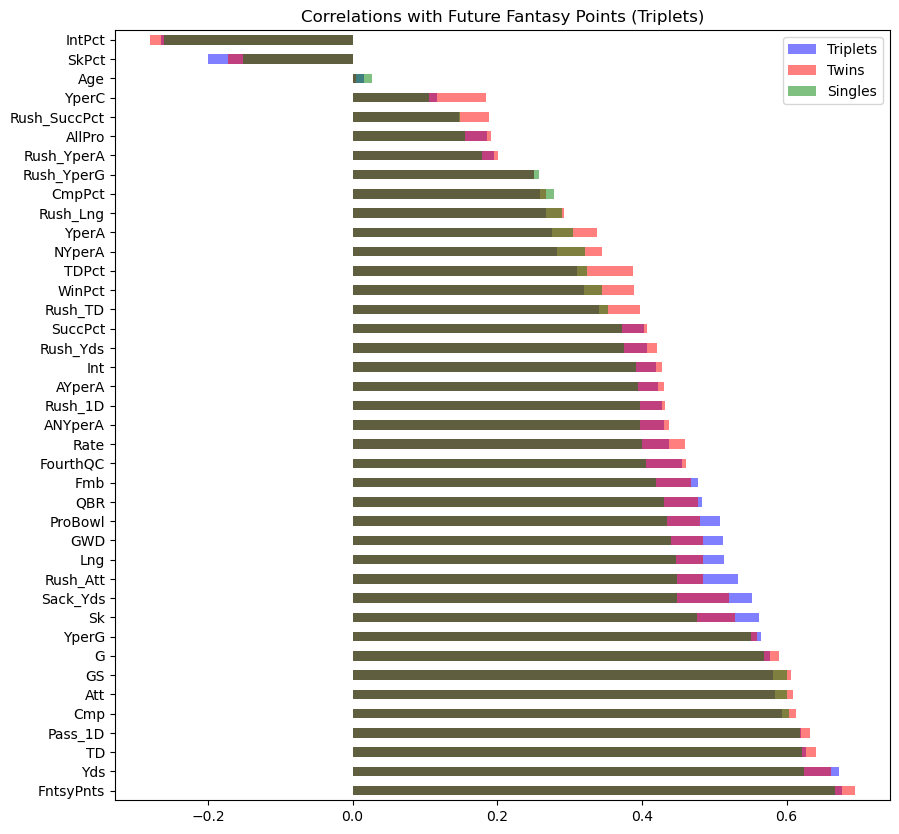

In [414]:
# Create correlations relative to 'FntsyPnts_y'
triplets_corr = triplets.corr()['FntsyPnts_y'].sort_values(ascending=False)
triplets_corr = triplets_corr.drop('FntsyPnts_y')

twins_corr = twins.corr()['FntsyPnts_y'].sort_values(ascending=False)
twins_corr = twins_corr.drop('FntsyPnts_y')

singles_corr = singles.corr()['FntsyPnts_y'].sort_values(ascending=False)
singles_corr = singles_corr.drop('FntsyPnts_y')

# plot correlations
plt.figure(figsize=(10, 10))
triplets_corr.plot(kind='barh', color='blue', alpha=0.5, label='Triplets')
twins_corr.plot(kind='barh', color='red', alpha=0.5, label='Twins')
singles_corr.plot(kind='barh', color='green', alpha=0.5, label='Singles')
plt.title('Correlations with Future Fantasy Points (Triplets)')
plt.legend()
plt.show()

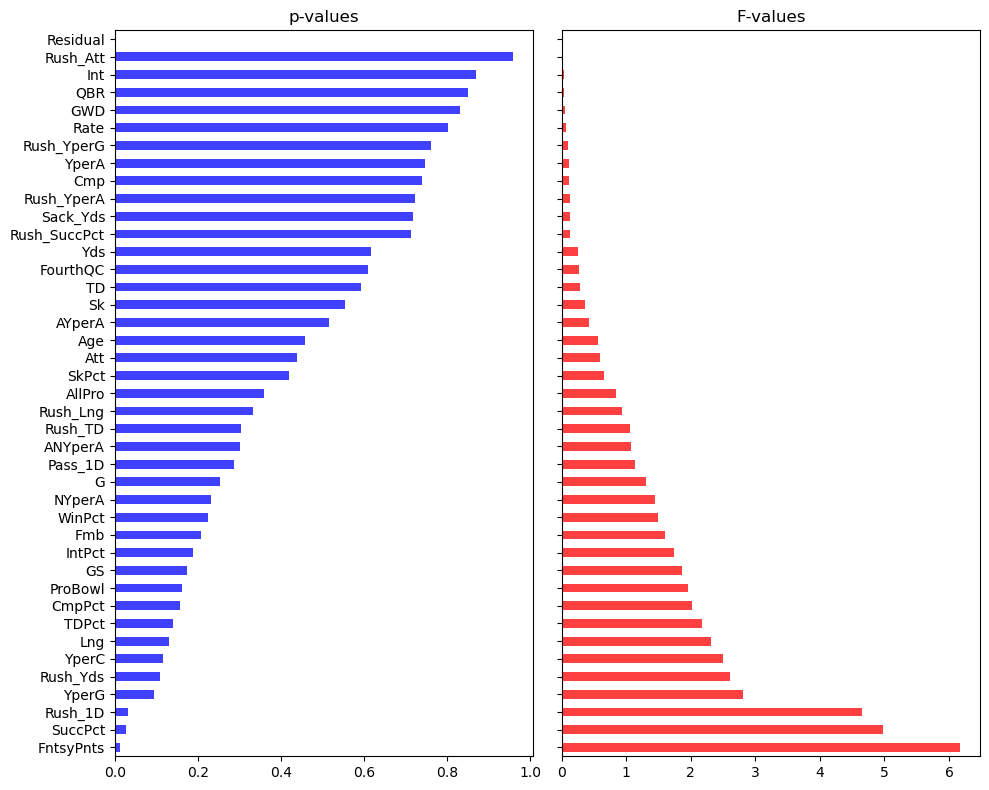

In [415]:
# Perform ols anova relative to 'FntsyPnts_y' in singles
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Clean data
df = singles.dropna()
df = df.drop(columns=['Player'])

# Define a formula
formula = 'FntsyPnts_y ~ ' + ' + '.join(df.columns[0:-1])

# Perform ANOVA
model = ols(formula, df).fit()
anova_table = anova_lm(model, typ=2)
anova_table = anova_table.sort_values('F', ascending=False)

# Plot p-values and F-values in two bar subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

anova_table['PR(>F)'].plot(kind='barh', ax=ax[0], color='blue', alpha=0.75)
anova_table['F'].plot(kind='barh', ax=ax[1], color='red', alpha=0.75)
ax[0].set_title('p-values')
ax[1].set_title('F-values')
ax[1].set_yticklabels([])

plt.tight_layout()
plt.show()